In [1]:
from tools.log_controller import LogController
from pathlib import Path

log_controller = LogController(config_path=Path('config', 'logging_config.json'))
log_controller.start()

In [2]:
from core.data_repository import DataRepository
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

data_repository = DataRepository(repo_path=Path('repo'))
AMZN_periodic_data = data_repository.get_dataframes()['AMZN_enhanced']




 2025-10-26 12:05:53 - data_repository - INFO - Loaded: AAPL
 2025-10-26 12:05:53 - data_repository - INFO - Loaded: AMZN_enhanced
 2025-10-26 12:05:53 - data_repository - INFO - Loaded: IBM
 2025-10-26 12:05:53 - data_repository - INFO - Loaded: AMZN
 2025-10-26 12:05:53 - data_repository - INFO - Loaded periodic stock market data for: {'AAPL', 'AMZN', 'IBM', 'AMZN_enhanced'}


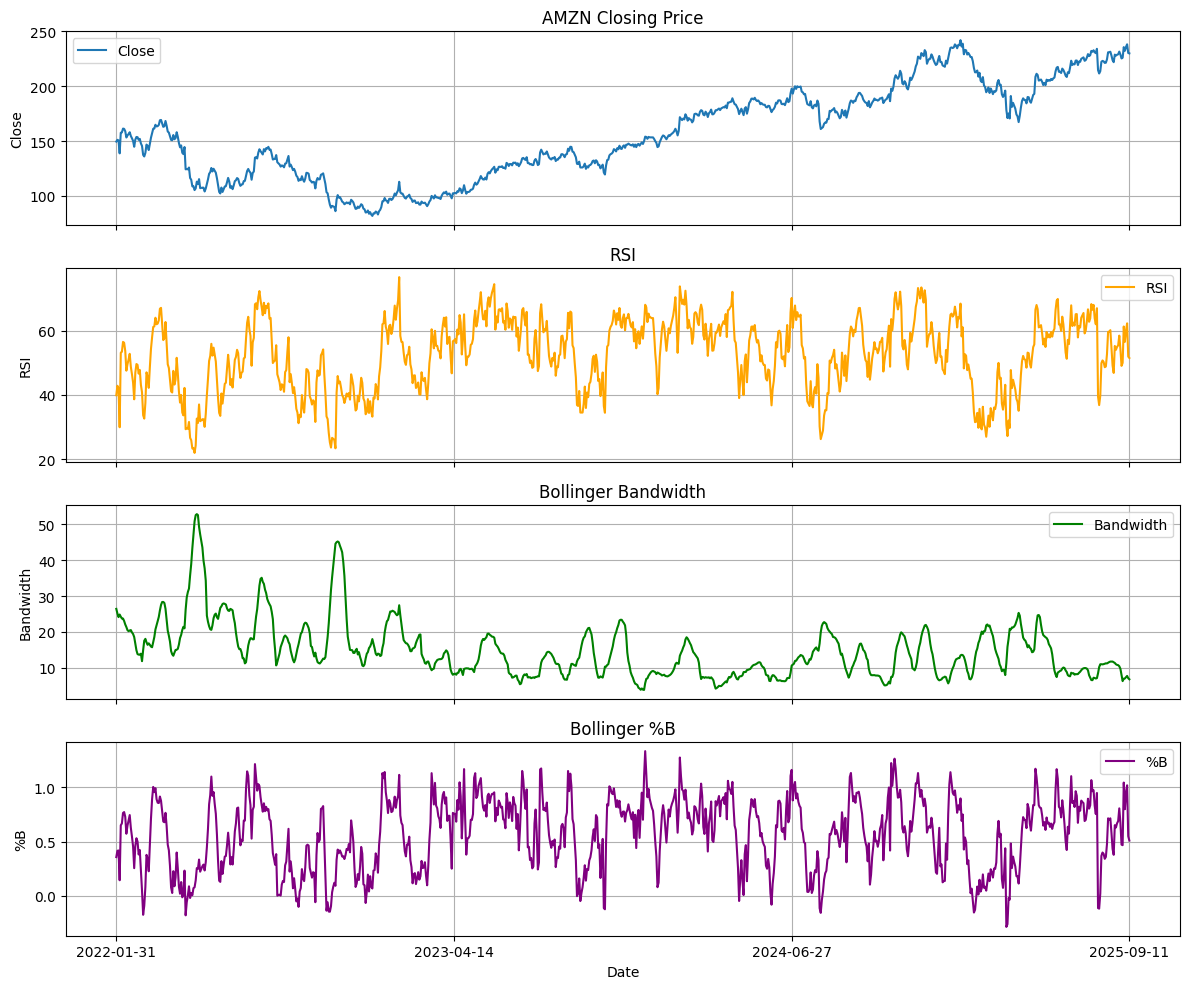

In [3]:
from tools.data_visualizer import plot_enhanced_features

plot_enhanced_features(AMZN_periodic_data)

In [4]:
from core.data_preparator import DataPreparator
timesteps_lookback = 3
AMZN_supervised_data = DataPreparator.reformat_periodic_to_supervised_data(dataframe=AMZN_periodic_data, target_column='Close', t=timesteps_lookback)
display(AMZN_supervised_data)
display(AMZN_periodic_data)

 2025-10-26 12:06:00 - data_preparator - INFO - Preparing data for target column: Close, with t=3
 2025-10-26 12:06:01 - data_preparator - INFO - Adding technical indicators to supervised data


,Close,Close_0,Close_1,Close_2,RSI,Bandwidth,%B
Date,,,,,,,
2022-02-03,138.845505,150.612503,151.193497,149.573502,29.931942,24.833632,0.141874
2022-02-04,157.639496,138.845505,150.612503,151.193497,53.155893,24.232240,0.649775
2022-02-07,157.935501,157.639496,138.845505,150.612503,53.417772,23.718960,0.667875
2022-02-08,161.413498,157.935501,157.639496,138.845505,56.495267,23.709387,0.764630
2022-02-09,161.189499,161.413498,157.935501,157.639496,56.237572,23.028714,0.772386
...,...,...,...,...,...,...,...
2025-09-05,232.330002,235.679993,225.990005,225.339996,56.526344,6.962863,0.798986
2025-09-08,235.839996,232.330002,235.679993,225.990005,60.031290,7.323344,0.954099
2025-09-09,238.240005,235.839996,232.330002,235.679993,62.271145,7.674673,1.020037


,Close,High,Low,Open,Volume,RSI,Bandwidth,%B
Date,,,,,,,,
2022-01-31,149.573502,150.360504,144.300507,144.750000,78308000,39.905046,26.412278,0.356150
2022-02-01,151.193497,151.707993,147.627502,150.000000,59220000,42.848523,25.132890,0.414336
2022-02-02,150.612503,155.074997,148.863495,155.050507,87330000,42.052984,24.118402,0.417377
2022-02-03,138.845505,144.247498,138.332993,141.737503,225532000,29.931942,24.833632,0.141874
2022-02-04,157.639496,161.199997,150.608002,155.606506,253456000,53.155893,24.232240,0.649775
...,...,...,...,...,...,...,...,...
2025-09-05,232.330002,236.000000,231.929993,235.190002,36721800,56.526344,6.962863,0.798986
2025-09-08,235.839996,237.600006,233.750000,234.940002,33947100,60.031290,7.323344,0.954099
2025-09-09,238.240005,238.850006,235.080002,236.360001,27033800,62.271145,7.674673,1.020037


In [5]:
from core.dataset import StockDataset
from sklearn.model_selection import train_test_split
import pandas as pd

AMZN_train_dataset, AMZN_test_dataset = train_test_split(AMZN_supervised_data, test_size=.1, shuffle=False, random_state=42)
AMZN_train_dataset, AMZN_validation_dataset = train_test_split(AMZN_train_dataset, test_size=.2, shuffle=False, random_state=42)

In [6]:
from core.data_preparator import DataPreparator
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

AMZN_train_dataset, AMZN_validation_dataset, AMZN_test_dataset = DataPreparator.scale_datasets(
    train_dataset=AMZN_train_dataset,
    validation_dataset=AMZN_validation_dataset,
    test_dataset=AMZN_test_dataset,
    scaler_X=scaler_X,
    scaler_y=scaler_y,
    target_column='Close'
)

display(AMZN_train_dataset.head())

 2025-10-26 12:06:03 - data_preparator - INFO - Scaling datasets for target column: Close


,Close_0,Close_1,Close_2,RSI,Bandwidth,%B,Close
Date,,,,,,,
2022-02-03,0.582099,0.587016,0.573308,0.145938,0.428902,0.213677,0.482531
2022-02-04,0.482531,0.582099,0.587016,0.570415,0.416660,0.548114,0.641559
2022-02-07,0.641559,0.482531,0.582099,0.575202,0.406212,0.560032,0.644064
2022-02-08,0.644064,0.641559,0.482531,0.631451,0.406017,0.623742,0.673494
2022-02-09,0.673494,0.644064,0.641559,0.626741,0.392162,0.628850,0.671598


In [7]:
AMZN_train_dataset = StockDataset(AMZN_train_dataset, ticker='AMZN_ENHANCED')
AMZN_validation_dataset = StockDataset(AMZN_validation_dataset, ticker='AMZN_ENHANCED')
AMZN_test_dataset = StockDataset(AMZN_test_dataset, ticker='AMZN_ENHANCED')

 2025-10-26 12:06:03 - dataset - INFO - Created stock dataset for AMZN_ENHANCED, focusing target: Close
 2025-10-26 12:06:03 - dataset - INFO - Created stock dataset for AMZN_ENHANCED, focusing target: Close
 2025-10-26 12:06:03 - dataset - INFO - Created stock dataset for AMZN_ENHANCED, focusing target: Close


In [8]:
# from models.lstm_model import LSTMStockModel

# best_params, best_value = LSTMStockModel.optimize_hyperparameters(
#     train_dataset=AMZN_train_dataset,
#     validation_dataset=AMZN_validation_dataset,
#     feature_number=feature_number,
#     ticker='AMZN_ENHANCED',
#     input_dim=1,
#     output_dim=1,
#     n_trials=100
# )
# print(f'Best hyperparameters: {best_params}, Best MSE Loss: {best_value}')

In [9]:
from models.lstm_model import LSTMStockModel

lstm_enhanced_model = LSTMStockModel(
    id='base_amzn_model',
    ticker='AMZN',
    input_dim=1,
    hidden_dim=64,
    layer_dim=2,
    output_dim=1
)

 2025-10-26 12:06:03 - model - INFO - Model(id=base_amzn_model,
ticker=('AMZN',),
input_dimension=1),
hidden_dimension=64,
layer_dimension=2,
output_dimension=1)


/home/emdablju/Documents/projects/kalman_stock_prediction/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
from torch.optim import Adam
from torch.nn import MSELoss

optimizer = Adam(lstm_enhanced_model.parameters(), lr=0.001)
loss_function = MSELoss()

In [11]:
from torch.utils.data import DataLoader
import torch
import numpy as np


AMZN_train_data_loader = DataLoader(AMZN_train_dataset, batch_size=16, shuffle=False)
AMZN_validation_data_loader = DataLoader(AMZN_validation_dataset, batch_size=10, shuffle=False)
epochs = 50
feature_number = AMZN_train_dataset.X.shape[1]

train_mse_list, val_mse_list, train_r2_list, val_r2_list, val_actuals, val_predictions, val_errors = lstm_enhanced_model.perform_training(
    train_loader=AMZN_train_data_loader,
    validation_loader=AMZN_validation_data_loader,
    optimizer=optimizer,
    loss_function=loss_function,
    epochs=epochs,
    feature_number=feature_number
)

 2025-10-26 12:06:05 - model - INFO - Epoch [1/50]
 2025-10-26 12:06:05 - model - INFO - Train MSE: 0.087802, R2: -0.3065
 2025-10-26 12:06:05 - model - INFO - Validation MSE: 0.102132, R2: -2.9147
 2025-10-26 12:06:06 - model - INFO - Epoch [2/50]
 2025-10-26 12:06:06 - model - INFO - Train MSE: 0.135288, R2: -1.0130
 2025-10-26 12:06:06 - model - INFO - Validation MSE: 0.494317, R2: -17.9472
 2025-10-26 12:06:06 - model - INFO - Epoch [3/50]
 2025-10-26 12:06:06 - model - INFO - Train MSE: 0.077799, R2: -0.1576
 2025-10-26 12:06:06 - model - INFO - Validation MSE: 0.321643, R2: -11.3286
 2025-10-26 12:06:06 - model - INFO - Epoch [4/50]
 2025-10-26 12:06:06 - model - INFO - Train MSE: 0.095268, R2: -0.4176
 2025-10-26 12:06:06 - model - INFO - Validation MSE: 0.375417, R2: -13.3897
 2025-10-26 12:06:06 - model - INFO - Epoch [5/50]
 2025-10-26 12:06:06 - model - INFO - Train MSE: 0.079869, R2: -0.1884
 2025-10-26 12:06:06 - model - INFO - Validation MSE: 0.294032, R2: -10.2702
 2025-

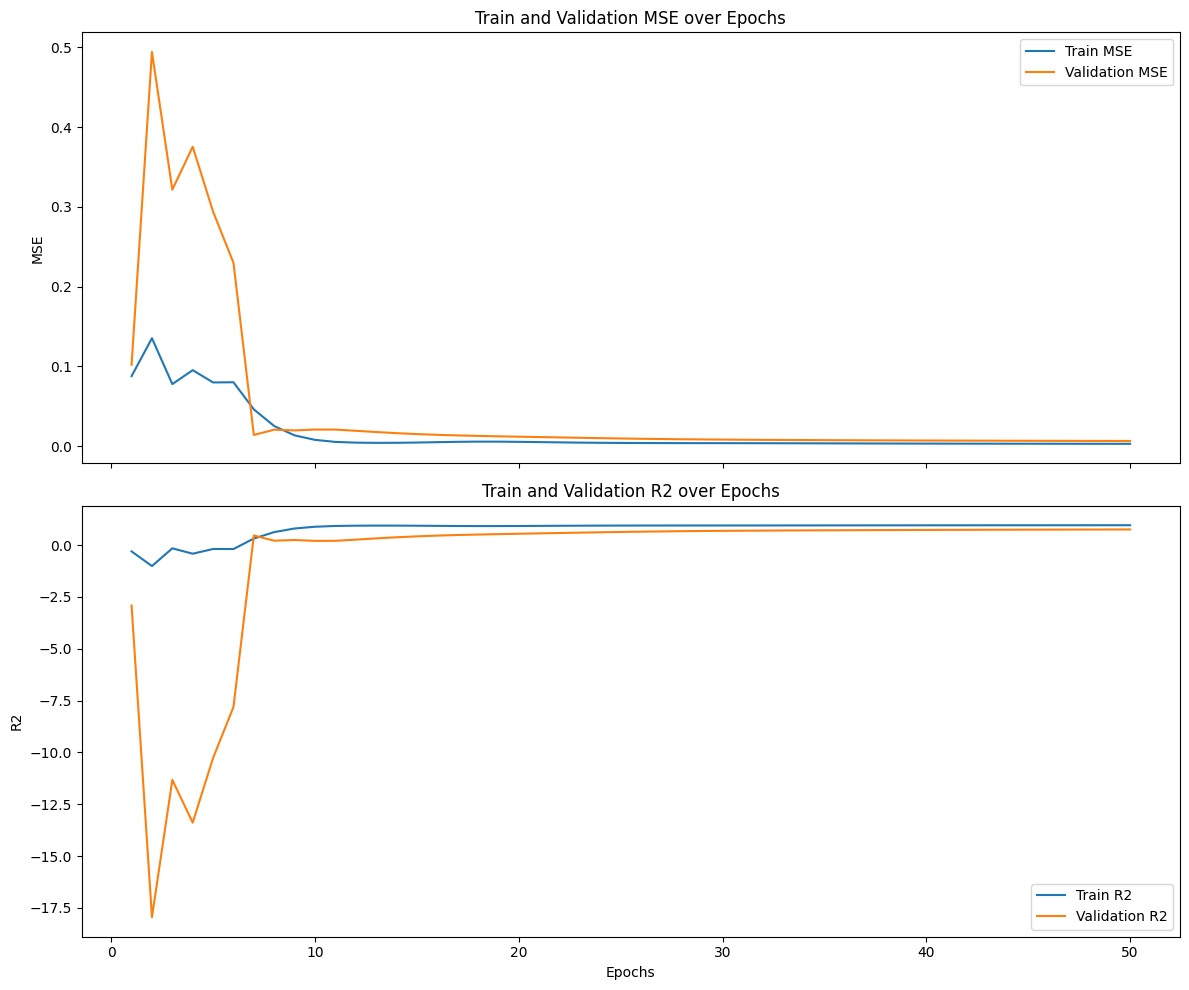

In [12]:
from tools.data_visualizer import plot_performance_metrics

plot_performance_metrics(train_mse_list, val_mse_list, train_r2_list, val_r2_list, epochs)

In [13]:
from torch.utils.data import DataLoader
import torch

AMZN_test_data_loader = DataLoader(AMZN_test_dataset, batch_size=10, shuffle=False)

actuals, predictions, errors = lstm_enhanced_model.evaluate(
    test_loader=AMZN_test_data_loader,
    loss_function=loss_function,
    scaler_y=scaler_y,
    feature_number=feature_number
)

Test RMSE: 0.0883
Test Loss (RMSE) on original scale: 10.1266


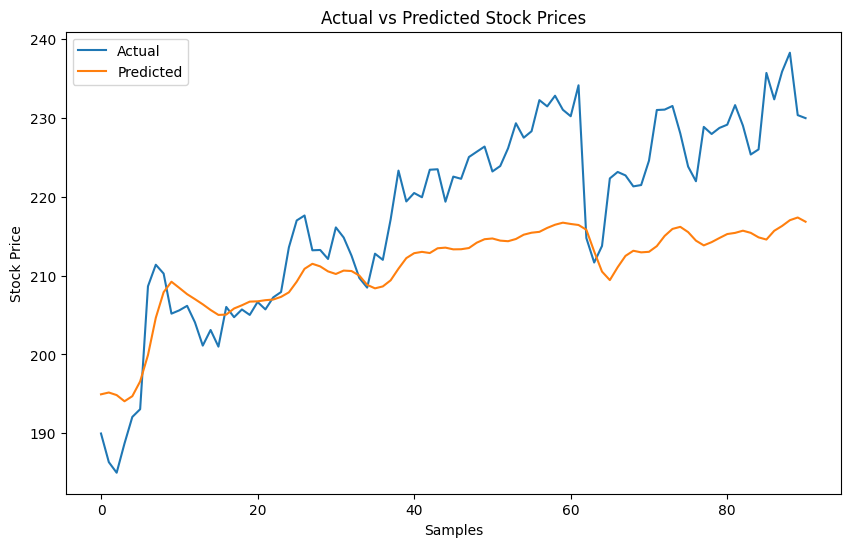

In [14]:
from tools.data_visualizer import plot_predictions

plot_predictions(actuals, predictions)

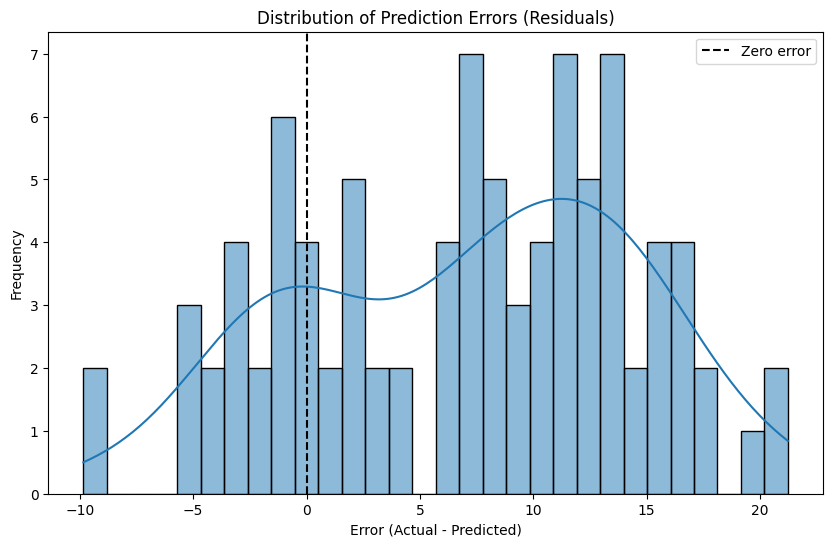

In [15]:
from tools.data_visualizer import plot_errors

plot_errors(errors)